In [1]:
import numpy as np
import sklearn.svm
import sklearn.model_selection
import matplotlib.pyplot as plt
from mnist import MNIST # pip install python-mnist

In [2]:
SEED = 73
N_JOBS = -1
N_CV = 5

np.random.seed(SEED)

# MNIST data

* MNIST data link: `https://github.com/mkolod/MNIST` (downloaded to `../../data/mnist/raw`)
* Original data link: `http://yann.lecun.com/exdb/mnist/` [BROKEN]

1. Load MNIST data
2. Select digits
   * Select digits: `[2, 3, 8, 9]`
   * Map classes (`index` to `digit`): `{0: 2, 1: 3, 2: 8, 3: 9}`
3. Normalize images
   * Subtract mean and divide by std
4. Shuffle data
5. Visualize one image

In [3]:
def get_mnist_data(sel_classes=[2, 3, 8, 9]):

    mndata = MNIST('../../data/mnist/raw/')
    mndata.gz = True

    # 1. Load Data
    train_images, train_labels = mndata.load_training()
    test_images, test_labels = mndata.load_testing()

    train_images = np.array(train_images, dtype=float)
    train_labels = np.array(train_labels)

    test_images = np.array(test_images, dtype=float)
    test_labels = np.array(test_labels)

    # 2. Select Digits
    if sel_classes is not None:
        sel_classes = np.sort(np.unique(sel_classes))
        
        train_sel_map = [l in sel_classes for l in train_labels]
        train_images = train_images[train_sel_map]
        train_labels = train_labels[train_sel_map]

        test_sel_map = [l in sel_classes for l in test_labels]
        test_images = test_images[test_sel_map]
        test_labels = test_labels[test_sel_map]

        class_mapping_rev = {digit: idx for idx, digit in enumerate(sel_classes)}
        class_mapping = {idx: digit for digit, idx in class_mapping_rev.items()}

        train_labels = np.array(list(map(lambda digit: class_mapping_rev[digit], train_labels)))
        test_labels = np.array(list(map(lambda digit: class_mapping_rev[digit], test_labels)))

    # 3. Normalize Data
    assert train_images.max() <= 255
    assert train_images.min() >= 0

    assert test_images.max() <= 255
    assert test_images.min() >= 0

    # train_images = train_images / 255.0
    # test_images = test_images / 255.0

    mean = train_images.mean()
    std = train_images.std()

    train_images = (train_images - mean) / std
    test_images = (test_images - mean) / std

    normalization_values = {"mean": mean, "std": std}

    # 4. Shuffle Data
    train_indices = list(range(len(train_labels)))
    np.random.shuffle(train_indices)

    train_images = train_images[train_indices]
    train_labels = train_labels[train_indices]

    test_indices = list(range(len(test_labels)))
    np.random.shuffle(test_indices)

    test_images = test_images[test_indices]
    test_labels = test_labels[test_indices]

    # 5. Sample Visualization
    sample_idx = 3
    print("Label : {}".format(class_mapping[train_labels[sample_idx]]))
    print(mndata.display((train_images[sample_idx] * normalization_values["std"]) + normalization_values["mean"]))

    return (train_images, train_labels), (test_images, test_labels), class_mapping, normalization_values

In [4]:
(train_images, train_labels), (test_images, test_labels), class_mapping, normalization_values = get_mnist_data()

Label : 3

............................
............................
............................
............................
............................
...............@@@..........
............@@@@@@@.........
...........@@@@@@@@.........
..........@@@@@@@@..........
......@@@@@..@@@@@..........
...@@@@@@@..@@@@@...........
...@@@......@@@.............
...........@@@@.............
..........@@@@@@@@@@........
........@@@@@@@@@@@@@@......
........@@@.....@@@@@@@.....
....................@@@.....
....................@@@.....
..................@@@@@.....
..........@@...@@@@@@@@.....
..........@@@@@@@@@@@@......
..........@@@@@@@@@@........
..........@@@@@.............
............................
............................
............................
............................
............................


In [5]:
print("* Train N Images : {}".format(len(train_images)))
print("* Test N Images  : {}".format(len(test_images)))
print("* Class Mapping  : {}".format(class_mapping))

print("\n* Train N Images Per Digit:")
print("\n".join(["Digit : {} - N Samples : {}".format(class_mapping[l], np.sum(train_labels == l)) for l in np.unique(train_labels)]))

print("\n* Test N Images Per Digit:")
print("\n".join(["Digit : {} - N Samples : {}".format(class_mapping[l], np.sum(test_labels == l)) for l in np.unique(test_labels)]))

print("\n* Normalization Values : {}".format(normalization_values))
print("\n* Train Mean : {}".format(train_images.mean()))
print("* Train Std  : {}".format(train_images.std()))
print("* Test Mean : {}".format(test_images.mean()))
print("* Test Std  : {}".format(test_images.std()))

* Train N Images : 23889
* Test N Images  : 4025
* Class Mapping  : {0: 2, 1: 3, 2: 8, 3: 9}

* Train N Images Per Digit:
Digit : 2 - N Samples : 5958
Digit : 3 - N Samples : 6131
Digit : 8 - N Samples : 5851
Digit : 9 - N Samples : 5949

* Test N Images Per Digit:
Digit : 2 - N Samples : 1032
Digit : 3 - N Samples : 1010
Digit : 8 - N Samples : 974
Digit : 9 - N Samples : 1009

* Normalization Values : {'mean': 35.89966776613949, 'std': 80.90959036437248}

* Train Mean : -1.046182475823586e-17
* Train Std  : 0.9999999999999992
* Test Mean : 0.006747606319406119
* Test Std  : 1.0082787449902055


# Dual NonLinear SVM

* Kernel Selection : Radial Basis Function ("rbf")

## Fit Dual NonLinear SVM with Default Params (exc. kernel="rbf")

In [6]:
def fit_nonlinear_svm_with_default_params():

    model = sklearn.svm.SVC(C=1.0,
                            kernel='rbf',
                            gamma='scale',
                            shrinking=True,
                            tol=0.001,
                            class_weight=None,
                            random_state=SEED)

    model.fit(train_images, train_labels)

    print("Parameters :\n{}".format(model.get_params()))

    print("\n\nTrain Accuracy : {}".format(model.score(train_images, train_labels)))
    print("Test Accuracy  : {}".format(model.score(test_images, test_labels)))

In [7]:
fit_nonlinear_svm_with_default_params()

Parameters :
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 73, 'shrinking': True, 'tol': 0.001, 'verbose': False}


Train Accuracy : 0.9933442170036418
Test Accuracy  : 0.9873291925465838


## Fit Dual NonLinear SVM with Grid Search

* Tuneable parameters: `["C", "gamma", "tol"]`

In [8]:
def fit_nonlinear_svm_with_grid_search_step(iter=0, tol_base=0.0001, c_base=1.0, ratio=10.0):

    model_gridsearch = sklearn.svm.SVC(C=1.0,
                                       kernel='rbf',
                                       gamma='scale', # scale, "auto"
                                       shrinking=True,
                                       tol=0.001,
                                       class_weight=None,
                                       random_state=SEED)


    param_grid = dict()
    param_grid["gamma"] = ["scale", "auto"]
    param_grid["tol"] = [tol_base / ratio, tol_base, tol_base * ratio]    
    param_grid["C"] = [c_base / ratio, c_base, c_base * ratio]

    print("\n## Iteration : {}\n".format(iter))
    
    print("* Search Space : {}".format(param_grid))

    model_gridsearch = sklearn.model_selection.GridSearchCV(model_gridsearch, param_grid, scoring="accuracy", cv=N_CV,
                                                            n_jobs=N_JOBS, verbose=0)

    model_gridsearch.fit(train_images, train_labels)

    best_model = model_gridsearch.best_estimator_
    best_params = model_gridsearch.best_params_
    best_score = model_gridsearch.best_score_

    print("\n* Best Parameters      : {}".format(best_params))
    print("* Best Accuracy [CV={}] : {}".format(N_CV, best_score))

    train_acc = best_model.score(train_images, train_labels)
    test_acc = best_model.score(test_images, test_labels)

    print("\nTrain Accuracy : {}".format(train_acc))
    print("Test Accuracy  : {}".format(test_acc))

    return best_params, best_model, train_acc, test_acc

In [9]:
def fit_nonlinear_svm_with_grid_search_with_ratio(best_params=None, best_model=None, best_train_acc=-1.0, best_test_acc=-1.0, ratio=10.0):

    print("\n# Ratio : {}\n".format(ratio))

    iter = 0

    while True:
        if best_params is None:
            tol_base = 0.001
            c_base = 1.0
        else:
            tol_base = best_params["tol"]
            c_base = best_params["C"]
                
        best_params_step, best_model_step, train_acc_step, test_acc_step = fit_nonlinear_svm_with_grid_search_step(iter=iter,
                                                                                                                   tol_base=tol_base,
                                                                                                                   c_base=c_base,
                                                                                                                   ratio=ratio)

        iter += 1
    
        if test_acc_step > best_test_acc:
            is_same_params = False
            
            if best_params_step == best_params:
                is_same_params = True
                
            best_params = best_params_step
            best_model = best_model_step
            best_train_acc = train_acc_step
            best_test_acc = test_acc_step

            if is_same_params:
                break
        else:
            break
    
    print("\n-----------------------------------\n")
    print("Ratio={} Best Parameters : {}".format(ratio, best_params))
    print("Ratio={} Train Accuracy  : {}".format(ratio, best_train_acc))
    print("Ratio={} Test Accuracy   : {}".format(ratio, best_test_acc))
    
    return best_params, best_model, best_train_acc, best_test_acc

In [10]:
def fit_nonlinear_svm_with_grid_search(ratios=[10.0, 5.0, 2.0]):

    best_params = None
    best_model = None
    best_train_acc = -1.0
    best_test_acc = -1.0

    for ratio in ratios:
        best_params_ratio, best_model_ratio, train_acc_ratio, test_acc_ratio = fit_nonlinear_svm_with_grid_search_with_ratio(
            best_params=best_params, best_model=best_model,
            best_train_acc=best_train_acc, best_test_acc=best_test_acc, ratio=ratio)

        if test_acc_ratio >= best_test_acc:
            best_params = best_params_ratio
            best_model = best_model_ratio
            best_train_acc = train_acc_ratio
            best_test_acc = test_acc_ratio
        else:
            break
    
    print("\n-----------------------------------\n")
    print("Best Parameters : {}".format(best_params))
    print("Train Accuracy  : {}".format(best_train_acc))
    print("Test Accuracy   : {}".format(best_test_acc))
    
    return best_params, best_model, best_train_acc, best_test_acc  

In [11]:
best_params, best_model, best_train_acc, best_test_acc = fit_nonlinear_svm_with_grid_search()


# Ratio : 10.0


## Iteration : 0

* Search Space : {'gamma': ['scale', 'auto'], 'tol': [0.0001, 0.001, 0.01], 'C': [0.1, 1.0, 10.0]}

* Best Parameters      : {'C': 10.0, 'gamma': 'scale', 'tol': 0.0001}
* Best Accuracy [CV=5] : 0.9878186279256165

Train Accuracy : 0.9999581397295827
Test Accuracy  : 0.9895652173913043

## Iteration : 1

* Search Space : {'gamma': ['scale', 'auto'], 'tol': [1e-05, 0.0001, 0.001], 'C': [1.0, 10.0, 100.0]}

* Best Parameters      : {'C': 10.0, 'gamma': 'scale', 'tol': 1e-05}
* Best Accuracy [CV=5] : 0.9878186279256165

Train Accuracy : 0.9999581397295827
Test Accuracy  : 0.9895652173913043

-----------------------------------

Ratio=10.0 Best Parameters : {'C': 10.0, 'gamma': 'scale', 'tol': 0.0001}
Ratio=10.0 Train Accuracy  : 0.9999581397295827
Ratio=10.0 Test Accuracy   : 0.9895652173913043

# Ratio : 5.0


## Iteration : 0

* Search Space : {'gamma': ['scale', 'auto'], 'tol': [2e-05, 0.0001, 0.0005], 'C': [2.0, 10.0, 50.0]}

* Best Parameters      

In [16]:
train_acc = best_model.score(train_images, train_labels)
test_acc = best_model.score(test_images, test_labels)

print("Best Parameters : {}".format(best_params))
print("Train Accuracy  : {}".format(train_acc))
print("Test Accuracy   : {}".format(test_acc))

Best Parameters : {'C': 10.0, 'gamma': 'scale', 'tol': 0.0001}
Train Accuracy  : 0.9999581397295827
Test Accuracy   : 0.9895652173913043


## Dual NonLinear SVM Results

### Default

* Parameters : {'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 73, 'shrinking': True, 'tol': 0.001, 'verbose': False}

* Train Accuracy : 0.9933442170036418
* Test Accuracy  : 0.9873291925465838

### Grid Search

* Best Parameters : {'C': 10.0, 'gamma': 'scale', 'tol': 0.0001} (Defaults: "C=1.0", "gamma=scale" and "tot=0.001")

* Train Accuracy  : 0.9999581397295827
* Test Accuracy   : 0.9895652173913043

### Comparison with Primal Linear SVM Results (`LinearSVM.ipyb`)

* [Primal Linear SVM] Best Parameters: {'C': 0.01, 'fit_intercept': True, 'intercept_scaling': 1.0, 'loss': 'squared_hinge', 'max_iter': 1000, 'penalty': 'l2', 'tol': 0.02}
* [Primal Linear SVM] Best Train Accuracy: 0.9496420946879317
* [Primal Linear SVM] Best Test Accuracy: 0.9455900621118012

* [Dual NonLinear SVM (RBF)] Best Parameters: {'C': 10.0, 'gamma': 'scale', 'tol': 0.0001} (Defaults: "C=1.0", "gamma=scale" and "tot=0.001")
* [Dual NonLinear SVM (RBF)] Best Train Accuracy: 0.9999581397295827
* [Dual NonLinear SVM (RBF)] Best Test Accuracy: 0.9895652173913043

* [Test] Improvement Ratio: 4.65%

## Dual NonLinear SVM Support Vector Visualization

In [17]:
support_vector_indices = best_model.support_
support_vectors = best_model.support_vectors_
support_vector_classes = [train_labels[idx] for idx in support_vector_indices]

assert len(support_vectors) == len(support_vector_classes)

support_vectors_grouped = dict()
for sv, sv_class in zip(support_vectors, support_vector_classes):
    if sv_class not in support_vectors_grouped:
        support_vectors_grouped[sv_class] = []

    support_vectors_grouped[sv_class].append(sv)

In [18]:
support_vectors_vis = dict()

for k, v in support_vectors_grouped.items():
    print("Class Index : {} - N Support Vectors : {}".format(k, len(v)))

    v = np.array(v)
    v = v.mean(axis=0)
    v = (v * normalization_values["std"]) + normalization_values["mean"]
    assert v.max() <= 255
    assert v.min() >= 0

    v = v.reshape(28, 28).astype(np.uint8)

    support_vectors_vis[k] = v

Class Index : 0 - N Support Vectors : 869
Class Index : 1 - N Support Vectors : 952
Class Index : 2 - N Support Vectors : 1195
Class Index : 3 - N Support Vectors : 707


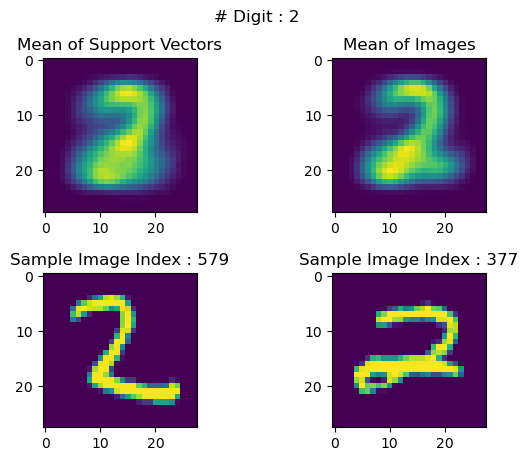

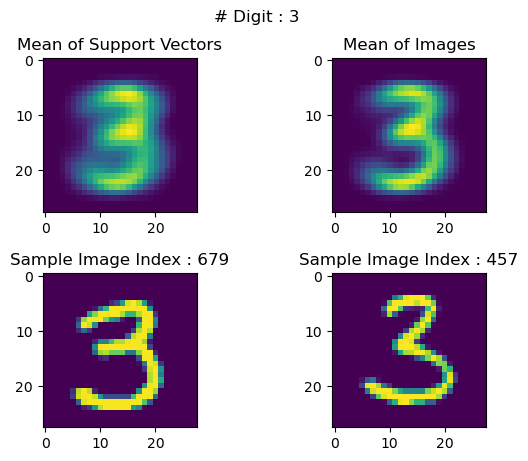

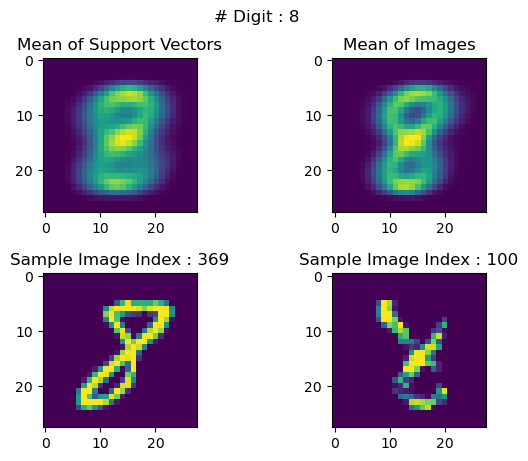

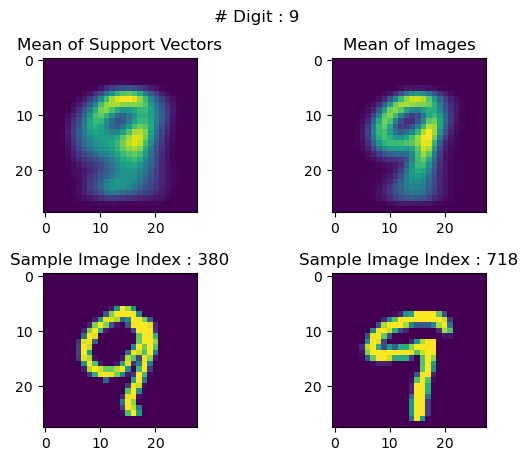

In [19]:
for class_idx, sv in support_vectors_vis.items():
    class_digit = class_mapping[class_idx]

    test_images_for_a_class = test_images[test_labels == class_idx]

    mean_test_images_for_a_class = test_images_for_a_class.mean(0)
    mean_test_images_for_a_class = (mean_test_images_for_a_class * normalization_values["std"]) + normalization_values["mean"]
    assert mean_test_images_for_a_class.max() <= 255
    assert mean_test_images_for_a_class.min() >= 0

    mean_test_images_for_a_class = mean_test_images_for_a_class.reshape(28, 28).astype(np.uint8)

    sample_image_indices = np.random.choice(list(range(len(test_images_for_a_class))), 2, replace=False)
    sample_images = [((test_images_for_a_class[idx] * normalization_values["std"]) + normalization_values["mean"]).reshape(28, 28).astype(np.uint8)
     for idx in sample_image_indices]

    fig, sub = plt.subplots(2, 2)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    sub[0][0].title.set_text('Mean of Support Vectors')
    sub[0][0].imshow(sv)
    sub[0][1].title.set_text('Mean of Images')
    sub[0][1].imshow(mean_test_images_for_a_class)
    sub[1][0].title.set_text('Sample Image Index : {}'.format(sample_image_indices[0]))
    sub[1][0].imshow(sample_images[0])
    sub[1][1].title.set_text('Sample Image Index : {}'.format(sample_image_indices[1]))
    sub[1][1].imshow(sample_images[1])

    fig.suptitle("# Digit : {}".format(class_digit))
    plt.show()